In [1]:
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

def show_datamodule(dm, batch_type):
    dm.prepare_data()
    dm.setup(stage='fit')
    train_dl = dm.train_dataloader()
    for i, batch in enumerate(train_dl):
        batch = batch[batch_type]
        for j in range(4):
            f, ax = plt.subplots(ncols=2, figsize=(20,12))
            ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
            ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
            for l in range(2):
                ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        plt.show()  
        break

### FLAIR

In [ ]:
%load_ext autoreload
%autoreload 2  

dm = datamodules.Flair(
    #data_path='/work/AI4GEO/users/fournip',
    data_path='/data',
    merge='hierarchical6',
    sup=3,
    unsup=5,
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [255]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

show_datamodule(dm, 'sup')

### PSEUDOSUP FLAIR

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import FlairPseudosup
import dl_toolbox.transforms as tf
from pathlib import Path
import torch

pl_dir = Path('/data/outputs/flair2_3_97/supervised_dummy/2023-09-05_102306/checkpoints/last_preds')  

dm = FlairPseudosup(
    data_path='/data',
    merge='hierarchical6',
    sup=3,
    unsup=0,
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [255]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    pl_dir=pl_dir,
    thresh=10
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['pseudosup']
    confs, labels = torch.max(batch['label'], dim=1)
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        ax[1].imshow(labels_to_rgb(labels[j].numpy(),dm.class_colors))
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break

### Digitanie

In [ ]:
%load_ext autoreload
%autoreload 2  

dm = datamodules.Digitanie(
    data_path='/work/AI4GEO/data/DATA/DATASETS',
    merge='all9',
    labeled_prop=3,
    unlabeled_prop=5,
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [8000.]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

show_datamodule(dm, 'sup')

### RESISC

In [ ]:
%load_ext autoreload
%autoreload 2  

dm = datamodules.Resisc(
    data_path='/data',
    merge='all45',
    sup=3,
    unsup=5,
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [255.]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

for i, batch in enumerate(train_dl):
    batch = batch['unsup']
    for j in range(4):
        f, ax = plt.subplots(ncols=1, figsize=(6,6))
        ax.imshow(batch['image'][j].numpy().transpose(1,2,0))
        ax.set_title(batch['label'][j])
    plt.show()  
    break

### Pseudosup resisc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


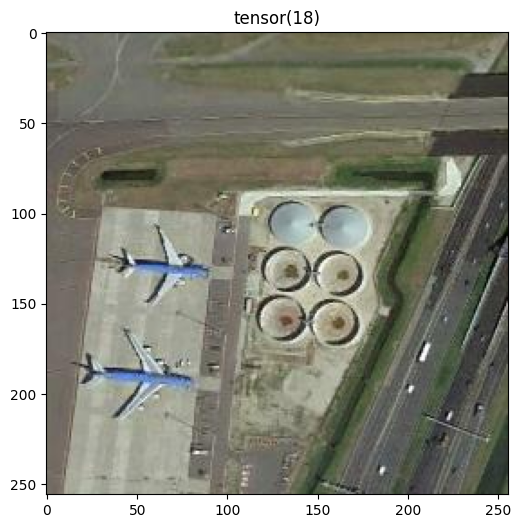

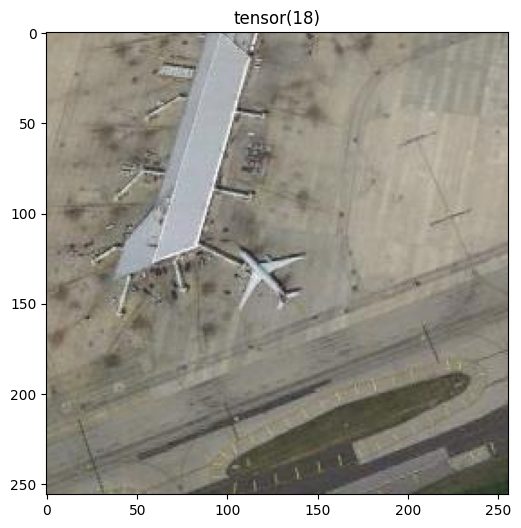

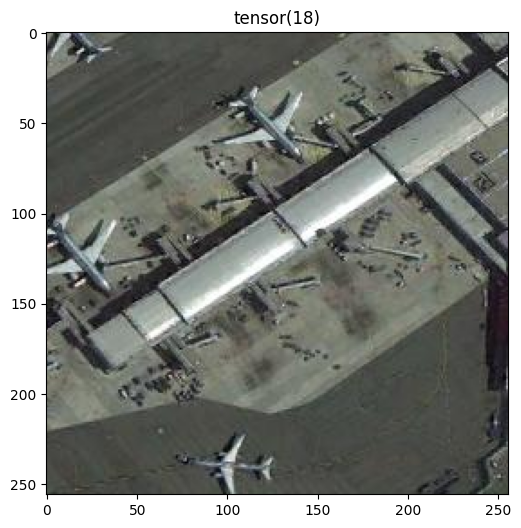

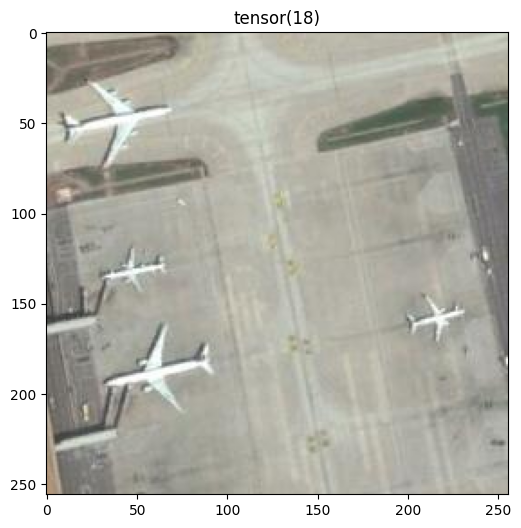

In [9]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import ResiscPseudosup
import dl_toolbox.transforms as tf

  
dm = ResiscPseudosup(
    data_path='/data',
    merge='all45',
    sup=3,
    unsup=0,
    dataset_tf=tf.StretchToMinmax([0]*3, [255.]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    pl_dir='/data/outputs/resisc_3_80/sup/2023-09-05_154623/checkpoints/last_preds',
    thresh=4000
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['pseudosup']
    for j in range(4):
        f, ax = plt.subplots(ncols=1, figsize=(6,6))
        ax.imshow(batch['image'][j].numpy().transpose(1,2,0))
        ax.set_title(batch['label'][j])
    plt.show()  
    break

### CITYSCAPES

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import Cityscapes
import dl_toolbox.transforms as tf

  
dm = Cityscapes(
    data_path='/data',
    merge='all19',
    prop=3,
    train_tf=tf.NoOp(),
    val_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['sup']
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break

### Semci

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import SemcityDatamodule
import dl_toolbox.transforms as tf

  
dm = SemcityDatamodule(
    data_path='/data',
    merge='all7',
    bands=[4,3,2],
    prop=3,
    train_tf=tf.StretchToMinmaxFromCsv(
        csv='~/dl_toolbox/dl_toolbox/datasets/semcity_stats.csv',
        min_p='p0.0',
        max_p='p99.0',
        bands=[4,3,2]
    ),
    val_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['sup']
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break